In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

BLDC Velocity Controller
========================

## Encoder-To-Velocity Module:
Quadtrature encoder module output count

Encoder Module Resolution $\frac{8192\textrm{ ticks}}{1 \textrm{ revolution}}$

Changes in count generate a time-per-tick based on fpga clock frequency $\frac{N \textrm{ }\mu \textrm{s}}{1 \textrm{ tick}}$

### Maximum Speed

Time between ticks is constrained to being as small as $1 \mu \textrm{s}$ which limits maximum speed to:
$$
\Big(\frac{1 \textrm{ } \mu \textrm{s}}{1 \textrm{ tick}}  \frac{8192 \textrm{ ticks}}{1 \textrm{ revolution}}  \frac{1 \textrm{ s}}{1000000 \textrm{ } \mu \textrm{s}} \frac{1 \textrm{ min}}{60 \textrm{sec}} \Big)^{-1} \approx 7324 \textrm{ rpm} \approx 122 \textrm{ rps}
$$


In [2]:
(8192/(1000000. * 60))**(-1)

7324.21875

Given the max encoder rate is 7500 rpm at this resolution according to the datasheet [PDF](http://www.cui.com/product/resource/amt10-v.pdf), these calcs are just fine.

### Minimum Speed
Output is a "tick period" in units: $\frac{\mu \textrm{s}}{\textrm{ tick}}$

Minimum speed is limited by the largest measurable time between ticks, which is limited by our precision.

For a 10-bit register storing "tick period", maximum tick frequency is 0x3FF


In [3]:
min_tick_period = 0x3FF
print("min_tick_period: {}".format(min_tick_period))
ticks_per_rev = 8192
rpm = (min_tick_period * ticks_per_rev/(1000000 * 60))**(-1)
rps = rpm/60.
print("rpm: {}".format(rpm))
print("rps: {}".format(rps))

min_tick_period: 1023
rpm: 7.159549120234604
rps: 0.11932581867057673


$$
\Big(\frac{4095 \textrm{ } \mu \textrm{s}}{1 \textrm{ tick}}  \frac{8192 \textrm{ ticks}}{1 \textrm{ revolution}}  \frac{1 \textrm{ s}}{1000000 \textrm{ } \mu \textrm{s}} \frac{1 \textrm{ min}}{60 \textrm{sec}} \Big)^{-1} \approx 7.16 \textrm{ rpm} \approx 0.12 \textrm{ rps}
$$

## Velocity LUT Generator

<IPython.core.display.Javascript object>


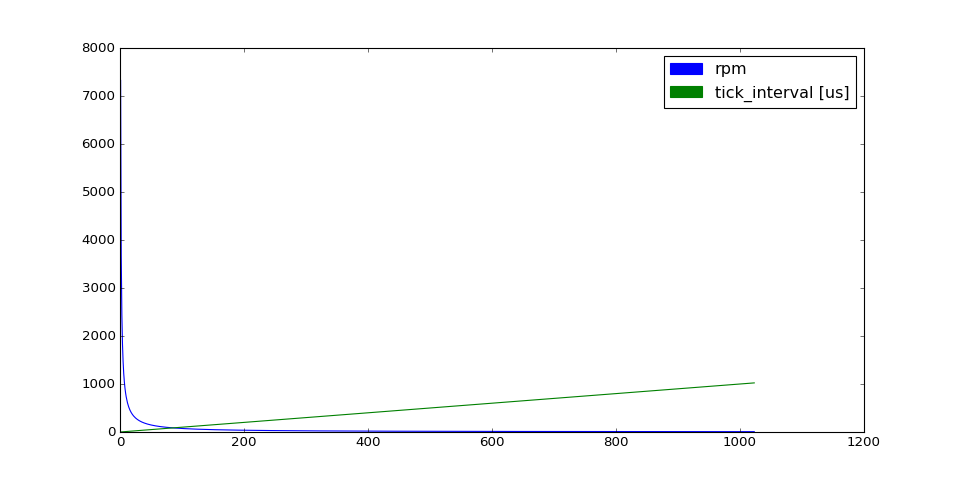

max speed: 7324.21875 rev/min
min speed: 7.159549120234604 rev/min


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib notebook 
# https://anaconda.org/ska/pygtk

max_tick_period = 0x3FF

plt.figure(figsize=(12,6))

def microsToRevPerMin(tick_interval_us):
    tick_per_rev = 8192
    us_per_s = 1000000
    s_per_min = 60
    return ((tick_interval_us * (tick_per_rev/us_per_s) * (1/s_per_min)))**(-1)

x = np.linspace(1, max_tick_period, num=max_tick_period)
plt.plot(x, microsToRevPerMin(x), '-', linewidth=1, color='blue', label="rpm")
rpm_label = mpatches.Patch(color='blue', label='rpm')
plt.plot(x, x, '-', linewidth=1, color='green')
tick_interval_label = mpatches.Patch(color='green', label='tick_interval [us]')
plt.legend(handles=[rpm_label, tick_interval_label])


print("max speed: {} rev/min".format(microsToRevPerMin(1)))
print("min speed: {} rev/min".format(microsToRevPerMin(max_tick_period)))

The LUT above falls similar to $\frac{1}{x}$, so it makes more sense to keep these values precomputed, rather than generate them on the fly.

## Generating Velocity

In [5]:
from math import log
from math import ceil


table_size = 2048
usec_per_sec = 1000000.
ticks_per_rev = 8192
scaling_factor = 64


print("--- Tick Time to Velocity Lookup Table")
print( "---   values autogenerated with Python")
print("")
print("--- table values are (velocity * scaling_factor)")
print("---     velocity units: [revolutions per second]")
print("---     scaling_factor = ", scaling_factor)
print("")
print("--- Note that a tick time of zero is undefined")
print("")

table_start = 1
table_end = table_size

last_velocity = 0  # dummy value
last_velocity_index = 0 # dummy value



first_table_value = int(round(microsToRevPerMin(1) * scaling_factor, 0))
num_bits = int(ceil(log(first_table_value, 2)))


print("WIDTH={0};".format(num_bits))
print("DEPTH={0};".format(table_end))
print("ADDRESS_RADIX=DEC;")
print("DATA_RADIX=DEC;")

print("")
print("CONTENT BEGIN")

# Print undefined value for a tick time of zero.
print("0  :  0; --- undefined")

# Iterate through smallest measurable tick time (max speed) to assumed
# largest tick time (min speed)
for tick_time in range(table_start, table_end + 1):
# Calculate velocity based in time-between-encoder-ticks.
    velocity =  int(round(microsToRevPerMin(tick_time) * scaling_factor, 0))
          #int( (usec_per_sec / (ticks_per_rev * tick_time)) * scaling_factor )

# Print either the range of identical velocities or a single entry for velocity.
    if (tick_time == table_start):
        # just velocity and tick time
        last_velocity = velocity
        last_velocity_index = tick_time
    else:
# Print unique velocities. Finish printing values at the end.
        if ((tick_time == table_end)  or (last_velocity != velocity)):
            # check if entry is unique.
            if (last_velocity_index == (tick_time - 1)):
                print("{0}  :  {1};".format(last_velocity_index,last_velocity))
            # entry is a range. print range of values with identical velocities.
            else:
                print("[{0}..{1}]  :  {2};"\
                    .format(last_velocity_index, tick_time - 1, last_velocity))
                last_velocity = velocity

            # Save velocity and tick time when we get a new velocity
            last_velocity = velocity
            last_velocity_index = tick_time

print("END;")

--- Tick Time to Velocity Lookup Table
---   values autogenerated with Python

--- table values are (velocity * scaling_factor)
---     velocity units: [revolutions per second]
---     scaling_factor =  64

--- Note that a tick time of zero is undefined

WIDTH=19;
DEPTH=2048;
ADDRESS_RADIX=DEC;
DATA_RADIX=DEC;

CONTENT BEGIN
0  :  0; --- undefined
1  :  468750;
2  :  234375;
3  :  156250;
4  :  117188;
5  :  93750;
6  :  78125;
7  :  66964;
8  :  58594;
9  :  52083;
10  :  46875;
11  :  42614;
12  :  39062;
13  :  36058;
14  :  33482;
15  :  31250;
16  :  29297;
17  :  27574;
18  :  26042;
19  :  24671;
20  :  23438;
21  :  22321;
22  :  21307;
23  :  20380;
24  :  19531;
25  :  18750;
26  :  18029;
27  :  17361;
28  :  16741;
29  :  16164;
30  :  15625;
31  :  15121;
32  :  14648;
33  :  14205;
34  :  13787;
35  :  13393;
36  :  13021;
37  :  12669;
38  :  12336;
39  :  12019;
40  :  11719;
41  :  11433;
42  :  11161;
43  :  10901;
44  :  10653;
45  :  10417;
46  :  10190;
47  :  9973

## Memory Saving

Notice above that our LUT would need to be 19 bits wide to hold the largest value. Memory-wise, this is very wasteful. Luckily, given the nature of our data, we can apply some compression. Since we know values drop of at a rate comparable to $\frac{1}{x}$, our first few values will be huge, but the ones following will be far smaller.

Check out the first few values.
    
    CONTENT BEGIN
    0  :  0; --- undefined
    1  :  468750;
    2  :  234375;
    3  :  156250;
    4  :  117188;
    5  :  93750;
    6  :  78125;
    7  :  66964;
    8  :  58594;
    9  :  52083;
    10  :  46875;
    11  :  42614;
    12  :  39062;
    13  :  36058;
    14  :  33482;
    15  :  31250;
    
Entry 1 is 19 bits wide, but entry 15 is only 16 bits wide. The remaining fit in a signed 16-bit integer.


## Filtering Velocity
The raw velocity (generated from the encoder and lookup table) is a noisy output and must be filtered.

Let's say our planned control loop runs at 20Khz. Hence we'll put a low pass filter at 10 Khz to cutoff excessively high-frequency noise in our system.


numerator: [0.0625, 0.5, 0.5, 0.0625]
denominator: [1, 0, 0.125, 0]


<IPython.core.display.Javascript object>


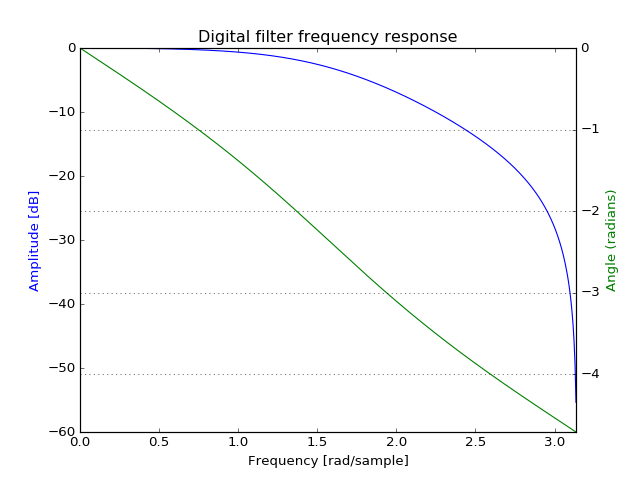

In [6]:
from scipy import signal
from math import log10

#num = [0, 1, -0.9375]
#denom = [0, 0.0625]

#num, denom = signal.iirfilter(3, .5, btype='lowpass', analog=False, ftype='butter')

num = [(1./16), .5, .5, (1./16)]
denom = [1, 0, 1/8, 0]
print("numerator: {}".format(num))
print("denominator: {}".format(denom))
w, h = signal.freqz(num, denom)

fig = plt.figure()
plt.title('Digital filter frequency response')
ax1 = fig.add_subplot(111)
plt.plot(w, 20 * np.log10(abs(h)), 'b')
plt.ylabel('Amplitude [dB]', color='b')
plt.xlabel('Frequency [rad/sample]')
ax2 = ax1.twinx()
angles = np.unwrap(np.angle(h))
plt.plot(w, angles, 'g')
plt.ylabel('Angle (radians)', color='g')
plt.grid()
plt.axis('tight')
plt.show()

For digital filters, the frequency is normalized to a unit circle. Hence $2\pi$ represents the sampling frequency and $\pi$ represents the nyquist frequency.

## IIR Filter Design

(Check out this [pdf](http://www.analog.com/media/en/training-seminars/design-handbooks/MixedSignal_Sect6.pdf) page 6.4 for more info on filter requirements.)

From the above coefficients, we get the following difference equation:

$$ \frac{1}{16} + \frac{1}{2}y[n] + \frac{1}{2}y[n - 1] + \frac{1}{16}y[n - 2] = 1 + \frac{1}{8}x[n - 2] $$

Normalized:
$$ \frac{1}{8} + y[n] + y[n - 1] + \frac{1}{8}y[n - 2] = 1 + \frac{1}{4}x[n - 2] $$

Hence, we have:
$$ y[n] = \frac{1}{4}x[n - 2] - y[n - 1] - \frac{1}{8}y[n - 2] + \frac{7}{8}$$

FPGAs can't do fractions with integer-based math, so we need to do some not-too-fancy bitmath:

$$ y[n] = \frac{8}{8}\big( \frac{1}{4}x[n - 2] - y[n - 1] - \frac{1}{8}y[n - 2] + \frac{7}{8} \big)$$

which ultimately yields:

$$y[n] = \big( 2x[n - 2] - 8y[n - 1] - y[n - 2] + 7 \big) >> 3 $$

where $>> 3$ represents a right shift.

## Filter Implementation in Hardware:
Luckily, this is easier that we might first think:

$x[n], x[n - 1], ...$ and $y[n], y[n-1], ...$ can both be represented with flip-flops and shift registers.


## Motor Commutation

### Alignment
Since we have a quadrature encoder without an index, the position of the rotor relative to the stator is unknown.
To align them, we can simply energize the 3 motor phases with a valid, known commutations sequence and wait sufficiently long (1-2seconds) for the both vectors to align. At this point, we can save this location an plant our phase angle always 90 (electrical) degrees ahead or behind this location at any given position to maintain maximum torque*.

**Note**: Right now, we're assuming that the inductance of the windings is minimal, which is fine for low speed applications. For high speed applications, the inductance of the windings plays a large role and will alter the position of the phase angle. Without measuring the current going through the motor windings, it's just not possible to truly know this location, though we can get around this issue by implementing "phase leading" (aka: pushing the phase angle ahead a few degrees to account for the winding inductance).

## Motor Commutation Waveforms
I'm implementing sinusoidal commutation, which works fine at low speeds.

The figure below represents one electrical cycle. One motor revolution (or mechanical cycle), however, consists of several electrical cycles, which is determined by the number of pole pairs.

Most of the typical hobbyist bldc motors have 7 pole pairs, giving us 7 electrical cycles per mechanical cycle.

For one electrical cycle, we must produce the following current waveform through the windings. (Note that y-axis units are arbitrary.)

One heads up: If we draw a vertical line down the middle of any x-location, we can think of these three values as the given currents through all three windings for a given electrical angle. If we've aligned our rotor and stator, than any point on this graph will produce the maximum torque for that given rotor position.

<IPython.core.display.Javascript object>


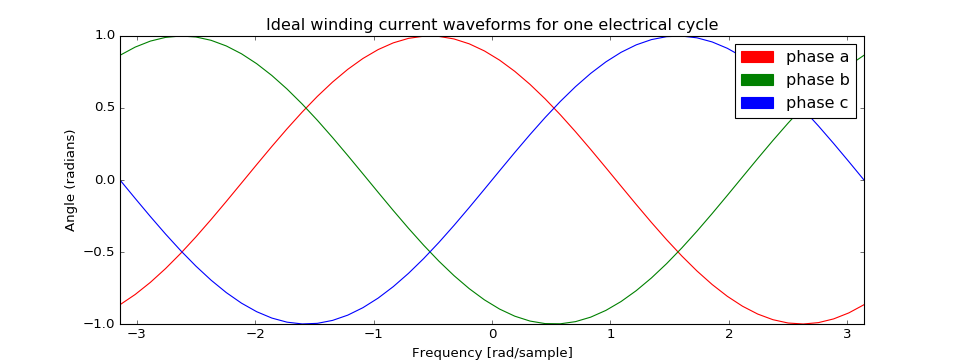

In [7]:
plt.figure(figsize=(12,4.5))
plt.title('Ideal winding current waveforms for one electrical cycle')
plt.xlabel('Frequency [rad/sample]')
plt.ylabel('Angle (radians)')

x = np.linspace(-np.pi, np.pi, 50)

plt.plot(x, np.sin(x + (2*np.pi/3)),'r')
plt.plot(x, np.sin(x - (2*np.pi/3)),'g')
plt.plot(x, np.sin(x),'b')

phase_a_label = mpatches.Patch(color='red', label='phase a')
phase_b_label = mpatches.Patch(color='green', label='phase b')
phase_c_label = mpatches.Patch(color='blue', label='phase c')

plt.legend(handles=[phase_a_label, phase_b_label, phase_c_label])

#plt.grid()
plt.axis('tight')
plt.show()

## Rotor and Stator Angles

To simplify things, let's assume negligible winding inductance (true at low speeds).

As the rotor rotates, the stator must output current through the windings (see above graph) such that the stator produces maximum torque on the rotor. This condition is met when the rotor and stator are 90 electrical degrees apart (again, provided winding inductance is negligible).


## Generating FET Output signals

These days, We can buy FET drivers off-the-shelf that will produce the right voltage levels to fully turn on and off a half-bridge. A half-bridge consists of either two N-channel mosfets in series or a P and N channel mosfet in series. Each motor phase winding is tied between the two mosfets in each half bridge.

Off-the-shelf FET drivers usually take a single input to drive both the high and low side of a half bridge. When the input is asserted (logic 1), the high side is on. When it's released (logic 0), the low side is on.

A PWM signal of sufficient frequency at a 50% duty cycle will float the half-bridge output. We'll also need to control the amplitude of this output to increase or decrease current (aka: torque). The equation for duty cycle is given below:

$$D(g,x) = \frac{g}{2}\sin(x) + \frac{g_\textrm{max}}{2} \textrm{ where } 0 \le g \le g_\textrm{max} \textrm{ and } g_\textrm{max} = 1$$

<IPython.core.display.Javascript object>


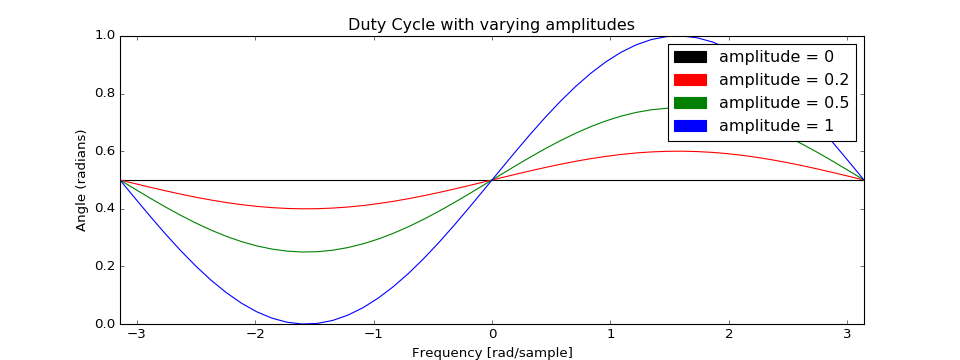

In [8]:
plt.figure(figsize=(12,4.5))
plt.title('Duty Cycle with varying amplitudes')
plt.xlabel('Frequency [rad/sample]')
plt.ylabel('Angle (radians)')

x = np.linspace(-np.pi, np.pi, 50)

def duty_cycle(g, x):
    g_max = 1.
    return (g/2.) * np.sin(x) + (g_max/2.) * np.sin(np.pi/2.)

plt.plot(x, duty_cycle(0, x),'black')
plt.plot(x, duty_cycle(.2, x),'r')
plt.plot(x, duty_cycle(.5, x),'g')
plt.plot(x, duty_cycle(1, x),'b')

amplitude_none = mpatches.Patch(color='black', label='amplitude = 0')
amplitude_small = mpatches.Patch(color='red', label='amplitude = 0.2')
amplitude_med = mpatches.Patch(color='green', label='amplitude = 0.5')
amplitude_large = mpatches.Patch(color='blue', label='amplitude = 1')

plt.legend(handles=[amplitude_none, amplitude_small, amplitude_med, amplitude_large])
#plt.grid()
plt.axis('tight')
plt.show()